Imports & Setup

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Load Dataset

In [3]:
df = pd.read_csv("synthetic_fraud_orders.csv")
print("Shape:", df.shape)
df.head()

Shape: (300, 10)


,order_id,customer_email,billing_country,shipping_country,amount,is_first_time_buyer,payment_avs_result,payment_cvv_result,num_orders_last_7_days,chargeback_flag
0,ORD_100000,user0@example.com,DE,UK,56.31,0,Y,Y,3,1
1,ORD_100001,user1@example.com,AU,CA,20.35,0,Y,Y,0,0
2,ORD_100002,user2@example.com,US,US,241.35,1,Y,Y,2,1
3,ORD_100003,user3@example.com,US,US,420.43,0,Y,Y,1,0
4,ORD_100004,user4@example.com,UK,AU,24.08,0,Y,Y,0,0


Basic Data Check

In [4]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   order_id                300 non-null    str    
 1   customer_email          300 non-null    str    
 2   billing_country         300 non-null    str    
 3   shipping_country        300 non-null    str    
 4   amount                  300 non-null    float64
 5   is_first_time_buyer     300 non-null    int64  
 6   payment_avs_result      300 non-null    str    
 7   payment_cvv_result      300 non-null    str    
 8   num_orders_last_7_days  300 non-null    int64  
 9   chargeback_flag         300 non-null    int64  
dtypes: float64(1), int64(3), str(6)
memory usage: 23.6 KB


In [5]:
df.isnull().sum()

order_id                  0
customer_email            0
billing_country           0
shipping_country          0
amount                    0
is_first_time_buyer       0
payment_avs_result        0
payment_cvv_result        0
num_orders_last_7_days    0
chargeback_flag           0
dtype: int64

Feature Engineering

In [6]:
df_fe = df.copy()

df_fe["country_mismatch"] = (
    df_fe["billing_country"] != df_fe["shipping_country"]
).astype(int)

df_fe["avs_failed"] = (df_fe["payment_avs_result"] == "N").astype(int)
df_fe["cvv_failed"] = (df_fe["payment_cvv_result"] == "N").astype(int)

df_fe["high_velocity"] = (df_fe["num_orders_last_7_days"] >= 4).astype(int)

df_fe["log_amount"] = np.log1p(df_fe["amount"])

Final Features

In [7]:
FEATURES = [
    "log_amount",
    "is_first_time_buyer",
    "country_mismatch",
    "avs_failed",
    "cvv_failed",
    "high_velocity",
    "num_orders_last_7_days"
]

TARGET = "chargeback_flag"

X = df_fe[FEATURES]
y = df_fe[TARGET]

X.head()
y.head()

0    1
1    0
2    1
3    0
4    0
Name: chargeback_flag, dtype: int64

Train / Test Split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

Feature Scaling

In [9]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Train Logistic Regression Model

In [10]:
model = LogisticRegression(
    penalty="l2",
    C=0.5,
    solver="liblinear",
    class_weight="balanced",
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train_scaled, y_train)

c:\Users\deadl\Desktop\Fraud Detection Task\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\deadl\Desktop\Fraud Detection Task\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'l2'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",0.5
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multicl

Model Evaluation

In [11]:
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.74      0.65      0.69        40
           1       0.44      0.55      0.49        20

    accuracy                           0.62        60
   macro avg       0.59      0.60      0.59        60
weighted avg       0.64      0.62      0.63        60

ROC-AUC: 0.6375


Confusion Matrix

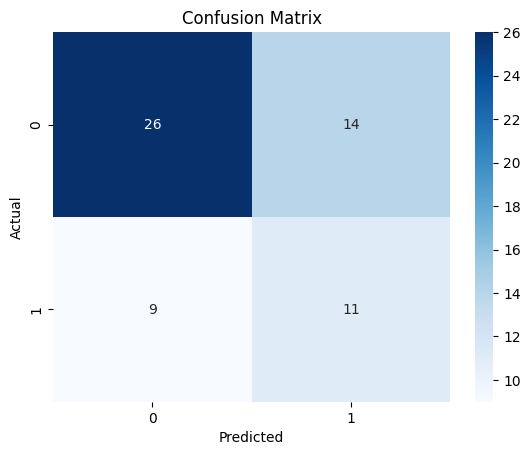

In [12]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Feature Importance

In [13]:
importance = pd.Series(
    model.coef_[0],
    index=FEATURES
).sort_values(ascending=False)

importance


avs_failed                0.736833
cvv_failed                0.576882
country_mismatch          0.386719
log_amount                0.298245
high_velocity             0.247651
is_first_time_buyer       0.151998
num_orders_last_7_days    0.009190
dtype: float64

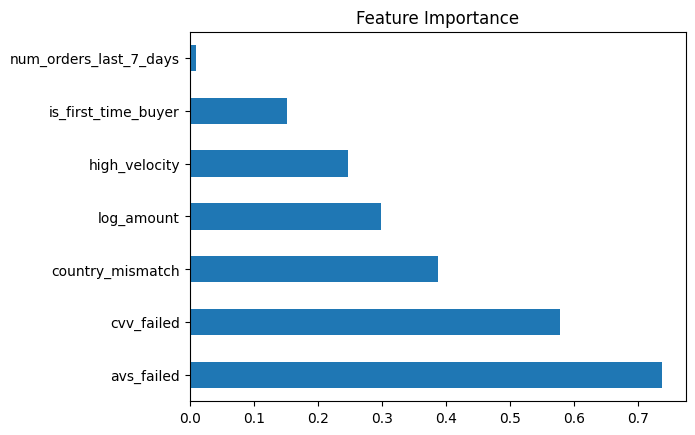

In [14]:
importance.plot(kind="barh", title="Feature Importance")
plt.show()


Risk Scoring Logic

In [15]:
def risk_decision(score):
    if score > 0.8:
        return "HIGH RISK – CANCEL"
    elif score > 0.5:
        return "SUSPICIOUS – VERIFY ID"
    else:
        return "LEGIT – APPROVE"


Sample Predictions

In [16]:
results = X_test.copy()
results["fraud_probability"] = y_prob
results["decision"] = results["fraud_probability"].apply(risk_decision)

results.head(10)


,log_amount,is_first_time_buyer,country_mismatch,avs_failed,cvv_failed,high_velocity,num_orders_last_7_days,fraud_probability,decision
165,4.489984,0,0,0,0,0,2,0.286790,LEGIT – APPROVE
211,3.699325,1,0,0,0,0,1,0.308521,LEGIT – APPROVE
86,4.333230,1,0,0,1,0,1,0.758472,SUSPICIOUS – VERIFY ID
80,2.585506,0,0,1,0,0,2,0.665696,SUSPICIOUS – VERIFY ID
246,4.671800,1,1,0,0,0,2,0.614183,SUSPICIOUS – VERIFY ID
269,5.194511,0,0,0,0,0,1,0.321446,LEGIT – APPROVE
29,2.789937,1,1,0,0,0,3,0.503590,SUSPICIOUS – VERIFY ID
90,4.770939,0,1,0,0,0,0,0.542294,SUSPICIOUS – VERIFY ID
270,4.259011,0,0,0,0,0,1,0.273899,LEGIT – APPROVE
97,3.571221,0,0,0,0,0,2,0.243287,LEGIT – APPROVE


Single Order Prediction for Checking Prediction

In [17]:
sample_order = pd.DataFrame([{
    "log_amount": np.log1p(800),
    "is_first_time_buyer": 1,
    "country_mismatch": 1,
    "avs_failed": 1,
    "cvv_failed": 1,
    "high_velocity": 1,
    "num_orders_last_7_days": 5
}])

sample_scaled = scaler.transform(sample_order)
score = model.predict_proba(sample_scaled)[0][1]

print("Fraud Score:", round(score, 2))
print("Decision:", risk_decision(score))


Fraud Score: 1.0
Decision: HIGH RISK – CANCEL


ROC Curve Graph

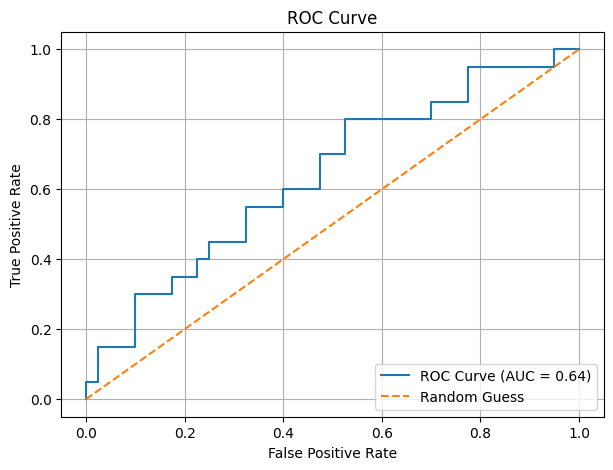

In [18]:
from sklearn.metrics import roc_curve, auc

# ROC values
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random Guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Threshold Tuning

In [19]:
thresholds = [0.3, 0.5, 0.7]

for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)

    print(f"Threshold = {t}")
    print(confusion_matrix(y_test, y_pred_t))
    print(classification_report(y_test, y_pred_t))

Threshold = 0.3
[[15 25]
 [ 4 16]]
              precision    recall  f1-score   support

           0       0.79      0.38      0.51        40
           1       0.39      0.80      0.52        20

    accuracy                           0.52        60
   macro avg       0.59      0.59      0.52        60
weighted avg       0.66      0.52      0.51        60

Threshold = 0.5
[[26 14]
 [ 9 11]]
              precision    recall  f1-score   support

           0       0.74      0.65      0.69        40
           1       0.44      0.55      0.49        20

    accuracy                           0.62        60
   macro avg       0.59      0.60      0.59        60
weighted avg       0.64      0.62      0.63        60

Threshold = 0.7
[[36  4]
 [14  6]]
              precision    recall  f1-score   support

           0       0.72      0.90      0.80        40
           1       0.60      0.30      0.40        20

    accuracy                           0.70        60
   macro avg       0.66

Final Decision

In [20]:
FINAL_THRESHOLD = 0.5

final_preds = (y_prob >= FINAL_THRESHOLD).astype(int)

print("Final Threshold:", FINAL_THRESHOLD)
print(confusion_matrix(y_test, final_preds))
print(classification_report(y_test, final_preds))

Final Threshold: 0.5
[[26 14]
 [ 9 11]]
              precision    recall  f1-score   support

           0       0.74      0.65      0.69        40
           1       0.44      0.55      0.49        20

    accuracy                           0.62        60
   macro avg       0.59      0.60      0.59        60
weighted avg       0.64      0.62      0.63        60



FINAL GRAPH VIEW

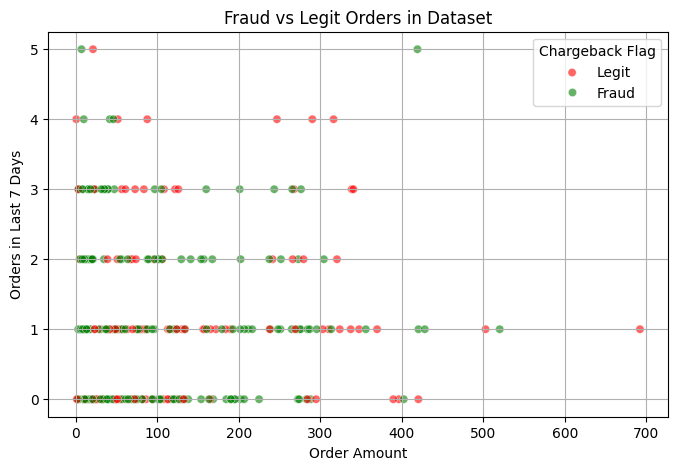

In [23]:
plt.figure(figsize=(8, 5))

sns.scatterplot(
    data=df,
    x="amount",
    y="num_orders_last_7_days",
    hue="chargeback_flag",
    palette={0: "green", 1: "red"},
    alpha=0.6
)

plt.xlabel("Order Amount")
plt.ylabel("Orders in Last 7 Days")
plt.title("Fraud vs Legit Orders in Dataset")
plt.legend(title="Chargeback Flag", labels=["Legit", "Fraud"])
plt.grid(True)
plt.show()

In [25]:
import joblib

joblib.dump(model, "model.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']